# Importing Modules

In [1]:
from utils import load_data
import yaml
from pharmbio.cp import plotting
import numpy as np
import warnings
from models import ConformalClassifier
warnings.filterwarnings("ignore")

In [2]:
with open("config.yaml", 'r') as file:
    config = yaml.safe_load(file)

# Defining Parameters

In [3]:
method = 'descriptors'  # 'descriptors', or 'fingerprints' or 'graph'
figerprint = 'morgan'  # 'morgan' or 'rdk' or 'atom pair' or 'topological torsion'
threshold = 'median'  # 'mean' or 'median' or 'max' or 'min' or 'std' or float value
embedding_size = 128  # any integer value

# Loading Data

In [4]:
loader = load_data(
    loader_type=method,
    task='classification',
    fingerprint_type=figerprint,
    threshold=threshold,
    test_size=config['test_size'],
    calibration_size=config['calibration_size'],
    descriptors=None,
    embedding_size=embedding_size,
    apply_dim_reduction=False,
    dim_reduction_method='mutual_info',
    n_components=10,
    top_k_features=20
    )

In [5]:
loader.dataset.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,12.052948,12.052948,0.203149,-0.203149,0.661287,10.480000,334.423,312.247,334.179361,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,12.905221,12.905221,0.041018,-4.942863,0.455296,11.937500,456.390,438.246,456.138481,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,12.739240,12.739240,0.023262,-1.824074,0.345685,9.962963,380.372,359.204,380.138365,146.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,9.553611,9.553611,0.557870,-1.257037,0.524740,15.130435,324.377,300.185,324.168522,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,11.855670,11.855670,0.169460,-0.570433,0.654459,10.480000,376.243,361.123,375.054132,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Splitting Dataset

In [6]:
splits = loader.split()
X_train, X_cal, X_test = splits['X_train'], splits['X_cal'], splits['X_test']
y_train, y_cal, y_test = splits['y_train'], splits['y_cal'], splits['y_test']

# Training Model

In [7]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [8]:
class_weight = (len(y_train) / (y_train.nunique() * y_train.value_counts())).round(2).to_dict()

In [9]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

In [10]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42, probability=True, class_weight=class_weight),
    SVC(gamma=2, C=1, random_state=42, probability=True, class_weight=class_weight),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42, class_weight=class_weight),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state=42, class_weight=class_weight),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
]

In [11]:
classifiers_objects = dict(zip(names, classifiers))

In [12]:
clf = ConformalClassifier(base_estimator=classifiers_objects['Random Forest'], confidence=0.95).fit(X_train, y_train)
clf.calibrate(X_cal, y_cal)

In [13]:
clf.evaluate(X_test, y_test)

,confidence,avg_set_size,singleton_fraction,coverage,efficiency,efficiency_2,validity_score,validity_score_2
0,0.95,1.862252,0.137748,0.970861,0.137748,0.073969,0.970861,0.979139


# Visualization

In [14]:
p_values = clf.wrapper.predict_p(X_test)

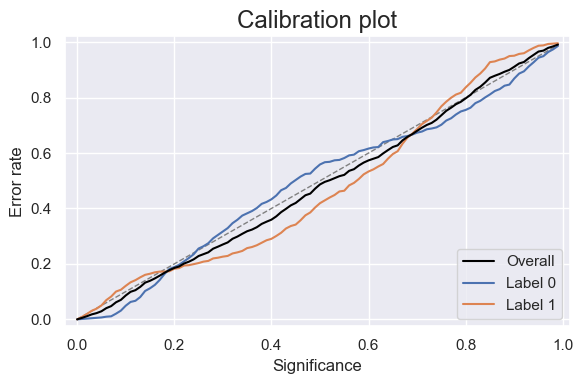

In [15]:
plot = plotting.plot_calibration_clf(y_test, p_values, title='Calibration plot', figsize=(6, 4))

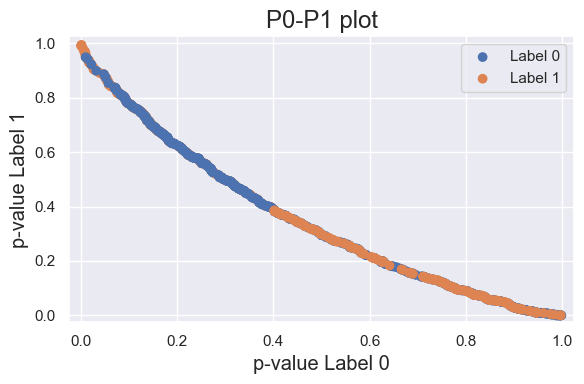

In [16]:
p0p1 = plotting.plot_pvalues(y_test, p_values, title='P0-P1 plot', figsize=(6, 4))

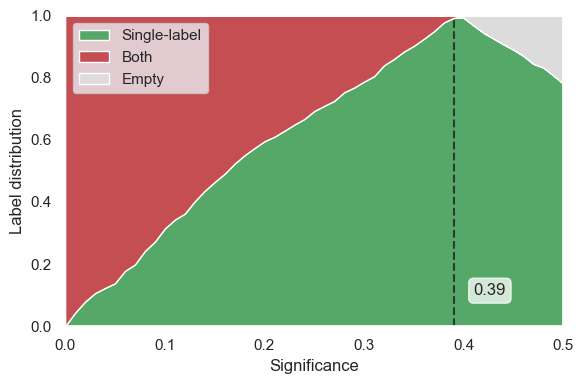

In [17]:
fig = plotting.plot_label_distribution(y_true=y_test, p_values=p_values, sign_vals=np.arange(0,.51,0.01), figsize=(6, 4))